In [1]:
import pylab as pl
%matplotlib inline
pl.rcParams['figure.figsize'] = 15, 15

In [2]:
import os.path
import csv
import numpy as np
import scipy.spatial
import pandas as pd

In [3]:

os.chdir("prepared_corpora/msrp_ns_va_nophrase_mfcwsd/")

In [4]:
def embedding_distance(embeddings, id1, id2):
    ii = id1 - 1  #Change from 1 indexed id, to 0 indexex embedding index
    jj = id2 - 1
    return scipy.spatial.distance.cosine(embeddings[ii,:], embeddings[jj,:])

In [5]:
def load_link_distances(link_filename, embeddings):
    links = np.loadtxt(link_filename, delimiter=",",skiprows=1, dtype=np.int)
    dists = pd.Series()
    for link in links:
        assert(len(link)==2)
        phrase_id = link[0]
        var_phrase_id = link[1]
        
        dists.loc[phrase_id] = embedding_distance(embeddings, phrase_id, var_phrase_id)
    return dists



In [6]:
def get_dists_table(embedding_filename, max_corruption = 10):
    embeddings = np.loadtxt(embedding_filename, delimiter=",")
    dists = pd.DataFrame()
    dists["paraphrase"] = load_link_distances("paraphrases.txt", embeddings)
    for corruption_level in range(1,max_corruption+1):
        link_filename = str(corruption_level)+"verb_anto_semantic_corruptions.txt"
        dists["verb_anto_" + str(corruption_level)] = load_link_distances(link_filename, embeddings)
        link_filename = str(corruption_level)+"noun_sym_semantic_corruptions.txt"
        dists["noun_sym_" + str(corruption_level)] = load_link_distances(link_filename, embeddings)
    return dists  
    

In [37]:
#rae_dists = get_dists_table("outVectors_RAE2011.csv")
#wiki_doc2vec_dists = get_dists_table("outVectors_wiki_doc2vec.csv")
#hansard_doc2vec_dists = get_dists_table("outVectors_hansard_doc2vec.csv")
wiki_doc2vec_dists = get_dists_table("outVectors_wiki_sentence_doc2vec.csv")

/usr/local/lib/python3.4/site-packages/numpy/lib/npyio.py:823: UserWarning: loadtxt: Empty input file: "6verb_anto_semantic_corruptions.txt"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)
/usr/local/lib/python3.4/site-packages/numpy/lib/npyio.py:823: UserWarning: loadtxt: Empty input file: "7verb_anto_semantic_corruptions.txt"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)
/usr/local/lib/python3.4/site-packages/numpy/lib/npyio.py:823: UserWarning: loadtxt: Empty input file: "8verb_anto_semantic_corruptions.txt"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)
/usr/local/lib/python3.4/site-packages/numpy/lib/npyio.py:823: UserWarning: loadtxt: Empty input file: "9verb_anto_semantic_corruptions.txt"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)
/usr/local/lib/python3.4/site-packages/numpy/lib/npyio.py:823: UserWarning: loadtxt: Empty input file: "10verb_anto_semantic_corruptions.txt"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)

In [38]:
def n_closer_than_paraphrase(prefix, dists):
    """
    prefix : eg "verb_anto_" or  "noun_sym_"
    """
    return [(dists.paraphrase > dists[prefix+str(nchanges)]).sum()/dists[prefix+str(nchanges)].count() for nchanges in range(1,11)]

comparative_distances = pd.DataFrame()

comparative_distances["n_changes"] = list(range(1,11))
#comparative_distances["RAE_noun_sym_lt_para"] = n_closer_than_paraphrase("noun_sym_", rae_dists)
#comparative_distances["RAE_verb_anto_lt_para"] = n_closer_than_paraphrase("verb_anto_", rae_dists)
comparative_distances["wiki_doc2vec_noun_sym_lt_para"] = n_closer_than_paraphrase("noun_sym_", wiki_doc2vec_dists)
comparative_distances["wiki_doc2vec_verb_anto_lt_para"] = n_closer_than_paraphrase("verb_anto_", wiki_doc2vec_dists)
#comparative_distances["hansard_doc2vec_noun_sym_lt_para"] = n_closer_than_paraphrase("noun_sym_", hansard_doc2vec_dists)
#comparative_distances["hansard_doc2vec_verb_anto_lt_para"] = n_closer_than_paraphrase("verb_anto_", hansard_doc2vec_dists)
comparative_distances

,n_changes,wiki_doc2vec_noun_sym_lt_para,wiki_doc2vec_verb_anto_lt_para
0,1,0.919503,0.914407
1,2,0.856260,0.835593
2,3,0.774374,0.768293
3,4,0.693761,0.583333
4,5,0.605166,0.000000
5,6,0.550162,NaN
6,7,0.384615,NaN
7,8,0.363636,NaN
8,9,0.333333,NaN
9,10,NaN,NaN


In [36]:
max_changes=5
def compare_sym_anto_distances(dists, max_changes):
    def inner():
        for nchanges in range(1,max_changes):
            verb_antos = dists["verb_anto_"+str(nchanges)]
            noun_syms =  dists["noun_sym_"+str(nchanges)]
            valid_dists = dists[np.logical_and(pd.notnull(verb_antos), pd.notnull(noun_syms))]
            yield (verb_antos > noun_syms).sum()/len(valid_dists)
    return list(inner())

comparative_distances.loc[0:max_changes-2,"rae_noun_sym_lt_verb_anto"] = compare_sym_anto_distances(rae_dists,max_changes)
comparative_distances.loc[0:max_changes-2,"wiki_doc2vec_noun_sym_lt_verb_anto"] = compare_sym_anto_distances(wiki_doc2vec_dists,max_changes)
comparative_distances.loc[0:max_changes-2,"hansard_doc2vec_noun_sym_lt_verb_anto"] = compare_sym_anto_distances(hansard_doc2vec_dists,max_changes)
comparative_distances

,n_changes,RAE_noun_sym_lt_para,RAE_verb_anto_lt_para,wiki_doc2vec_noun_sym_lt_para,wiki_doc2vec_verb_anto_lt_para,hansard_doc2vec_noun_sym_lt_para,hansard_doc2vec_verb_anto_lt_para,wiki_doc2vec_noun_sym_lt_verb_anto,hansard_doc2vec_noun_sym_lt_verb_anto,rae_noun_sym_lt_verb_anto
0,1,0.957171,0.945116,0.890067,0.894152,0.901228,0.905586,0.496288,0.498056,0.601979
1,2,0.914774,0.900000,0.812102,0.806780,0.829548,0.859322,0.512249,0.498886,0.576837
2,3,0.881001,0.792683,0.716348,0.707317,0.734610,0.743902,0.326087,0.456522,0.434783
3,4,0.840298,0.833333,0.605037,0.583333,0.622210,0.750000,0.250000,0.500000,0.250000
4,5,0.804428,1.000000,0.503075,0.000000,0.517835,0.000000,NaN,NaN,NaN
5,6,0.763754,NaN,0.411003,NaN,0.436893,NaN,NaN,NaN,NaN
6,7,0.750000,NaN,0.278846,NaN,0.230769,NaN,NaN,NaN,NaN
7,8,0.727273,NaN,0.227273,NaN,0.227273,NaN,NaN,NaN,NaN
8,9,0.888889,NaN,0.333333,NaN,0.111111,NaN,NaN,NaN,NaN
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
def drop_null_cols(df):
    keep_cols = [col for col in df.columns if not(all(pd.isnull(df.loc[:,col])))]
    return df.loc[:,keep_cols]
    


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5708441a90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f57256a7860>]], dtype=object)

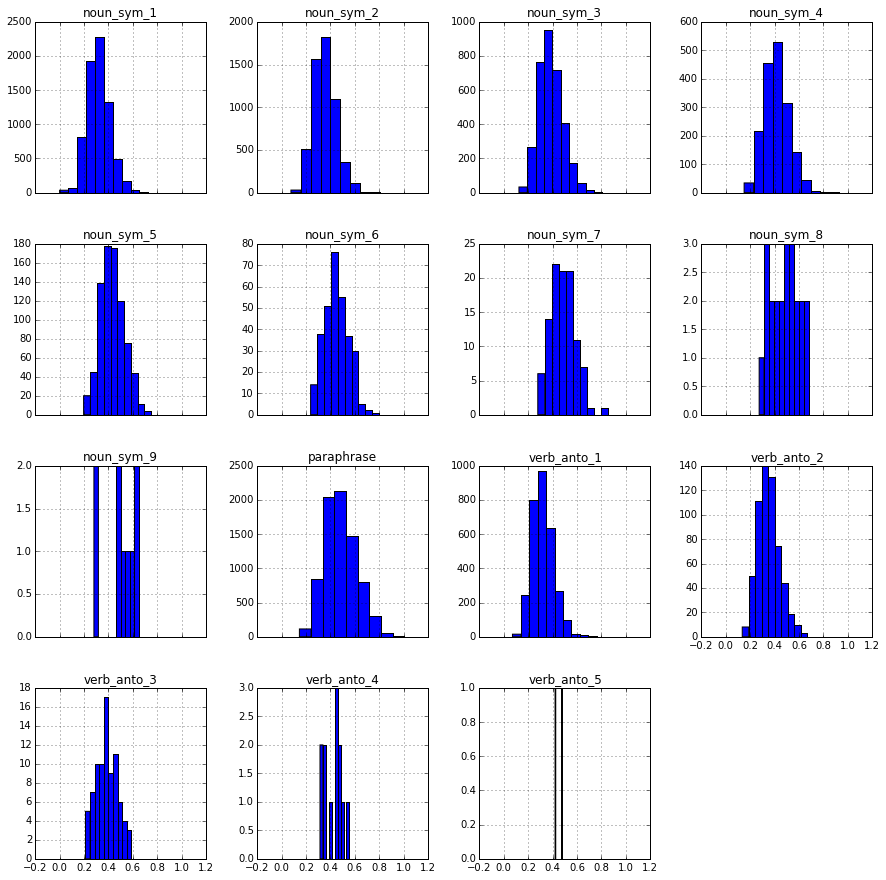

In [28]:
drop_null_cols(hansard_doc2vec_dists).hist(sharex=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f57255ee400>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f5724d72a90>]], dtype=object)

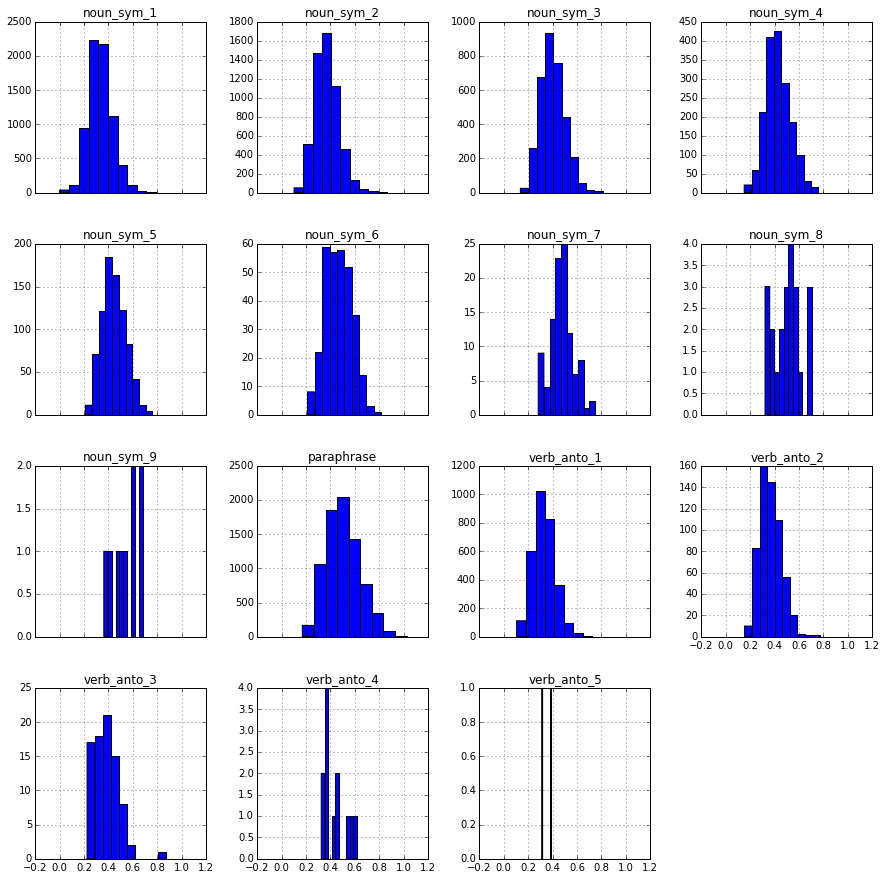

In [30]:
drop_null_cols(wiki_doc2vec_dists).hist(sharex=True)

In [26]:
drop_null_cols(rae_dists).hist(sharex=True)

NameError: name 'drop_null_cols' is not defined